In [6]:
import json
from owlready2 import get_ontology
import pandas as pd
import numpy as np
import re
import faiss
from tqdm import tqdm
from fuzzywuzzy import process
from owlready2 import get_ontology
import pickle
from sentence_transformers import SentenceTransformer, evaluation
import swifter
import hashlib
import duckdb
import uuid
from datetime import datetime
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
# import duckdb
# import pandas as pd
# import json

# def inspect_duckdb(db_path="document_vectors.db"):
#     """Inspect the contents of the DuckDB database"""
#     conn = duckdb.connect(db_path)
    
#     # 1. List all tables
#     tables = conn.execute("SHOW TABLES;").fetchall()
#     print("=== Tables in Database ===")
#     for table in tables:
#         print(table[0])
    
#     # 2. Show schema for each table
#     for table in tables:
#         table_name = table[0]
#         print(f"\n=== Schema for '{table_name}' ===")
#         schema = conn.execute(f"DESCRIBE {table_name};").fetchdf()
#         print(schema)
        
#         # 3. Show sample data (first 3 rows)
#         print(f"\nSample data from '{table_name}':")
#         try:
#             sample_data = conn.execute(f"SELECT * FROM {table_name} LIMIT 3;").fetchdf()
#             # Pretty-print JSON metadata if present
#             if 'metadata' in sample_data.columns:
#                 sample_data['metadata'] = sample_data['metadata'].apply(lambda x: json.loads(x) if x else {})
#             print(sample_data.to_markdown(index=False))
#         except duckdb.Error as e:
#             print(f"Couldn't read data: {e}")
    
#     # 4. Check document counts
#     if 'documents' in [t[0] for t in tables]:
#         counts = conn.execute("""
#             SELECT source_type, COUNT(*) as count 
#             FROM documents 
#             GROUP BY source_type;
#         """).fetchdf()
#         print("\n=== Document Counts by Type ===")
#         print(counts.to_markdown(index=False))
    
#     # 5. Check sample-feature relationships (if features table exists)
#     if 'features' in [t[0] for t in tables]:
#         sample_features = conn.execute("""
#             SELECT sample_id, COUNT(*) as feature_count
#             FROM features
#             GROUP BY sample_id
#             LIMIT 5;
#         """).fetchdf()
#         print("\n=== Sample Feature Counts (first 5 samples) ===")
#         print(sample_features.to_markdown(index=False))
    
#     conn.close()


# inspect_duckdb()

In [206]:
# def verify_data(conn, sample_id="Sample3"):
#     """Check what data exists for a sample"""
#     # Check summaries
#     summaries = conn.execute("""
#         SELECT source_id, LENGTH(text) as text_length 
#         FROM documents 
#         WHERE source_type = 'sample_summary'
#     """).fetchdf()
    
#     # Check features
#     features = conn.execute(f"""
#         SELECT sample_id, COUNT(*) as feature_count
#         FROM features
#         WHERE sample_id = '{sample_id}'
#         GROUP BY sample_id
#     """).fetchdf()
    
#     print("Existing summaries:")
#     print(summaries)
    
#     print(f"\nFeatures for {sample_id}:")
#     print(features)
    
#     return not summaries.empty

# # Usage
# conn = duckdb.connect("document_vectors.db")
# data_exists = verify_data(conn)
# print(f"\nData exists: {data_exists}")

In [207]:
# ncbi_ontology = get_ontology("ncbitaxon.owl").load()

In [208]:
COLUMN_NAME_MAP = {
        "sample_id": ["sample_id", "SampleID", "sampleid", "SampleId"],
        "environment": ["environment", "env", "condition", "habitat"],
        "species": ["species", "organism", "taxa"]
    }

def normalize_column(name):
    name = re.sub(r"[^a-zA-Z0-9]", "_", name)
    name = re.sub(r"([a-z])([A-Z])", r"\1_\2", name)  
    name = re.sub(r"_+", "_", name)

    # Map known columns to standardized names
    for standard_name, variations in COLUMN_NAME_MAP.items():
        if name in variations:
            return standard_name
    return name.strip("_").lower()

taxa_levels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]

In [211]:
def get_file_hash(file_path):
    """Generate SHA256 hash for the file to check for duplicates."""
    hash_sha256 = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            hash_sha256.update(byte_block)
    return hash_sha256.hexdigest()

# --- Check if the file is a duplicate by hash ---
def is_duplicate(file_path, con):
    """Check if file exists in DB using size + content hash."""
    file_hash = get_file_hash(file_path)
    
    # Check both size and hash for faster filtering
    result = con.execute("""
        SELECT COUNT(*) 
        FROM uploaded_files 
        WHERE file_hash = ?
    """, (file_hash,)).fetchone()
    
    return result[0] > 0 

def flatten_json(data):
    records = []

    for sample_id, sample_data in data.items():
        for feature_name, feature_data in sample_data.get("features", {}).items():
            # Extract the metadata and abundance values
            feature_metadata = feature_data.get("metadata", {})
            abundance_list = feature_data.get("abundance", [])
            feature_id = feature_data.get("feature_id", [None])[0]  # Get the feature ID (assume only one value)

            # For each abundance value, create a new record
            for abundance in abundance_list:
                record = {
                    "sample_id": sample_id,
                    "feature_id": feature_id,
                    "abundance": abundance
                }
                
                # Add metadata columns dynamically
                for metadata_key, metadata_value in feature_metadata.items():
                    record[metadata_key] = metadata_value[0] 

                records.append(record)

    df = pd.DataFrame(records)

    return df

COLUMN_NAME_MAP = {
        "sample_id": ["sample_id", "SampleID", "sampleid", "SampleId"],
        "environment": ["environment", "env", "condition", "habitat"],
        "species": ["species", "organism", "taxa"]
    }

def normalize_column(name):
    name = re.sub(r"[^a-zA-Z0-9]", "_", name)
    name = re.sub(r"([a-z])([A-Z])", r"\1_\2", name)  
    name = re.sub(r"_+", "_", name)

    # Map known columns to standardized names
    for standard_name, variations in COLUMN_NAME_MAP.items():
        if name in variations:
            return standard_name
    return name.strip("_").lower() 

con = duckdb.connect("document_vectors.db")
con.execute("""
CREATE TABLE IF NOT EXISTS uploaded_files (
    id UUID PRIMARY KEY DEFAULT uuid(),
    file_name TEXT NOT NULL,
    file_hash TEXT NOT NULL,
    upload_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    UNIQUE (file_hash) 
)
""")

con.execute("""
    SELECT * 
    FROM uploaded_files 
""").fetchall()

[]

In [210]:
tables = con.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'main'").fetchall()
for table in tables:
    table_name = table[0]
    print(f"Dropping table: {table_name}")
    con.execute(f"DROP TABLE IF EXISTS {table_name}")

Dropping table: documents
Dropping table: features
Dropping table: uploaded_files


In [212]:
file = 'uploads/Fujita2023_data.json'
file_hash = get_file_hash(file) 
description = "an in-vitro experiment of ocean inocula on peptide medium, sampled every day for 110 days"
print(file_hash)

# Check if the file is a duplicate
if is_duplicate(file, con):
    print(f"File {file} is a duplicate, skipping.")
else: 
    con.execute("""
        INSERT INTO uploaded_files (id, file_name, file_hash, upload_timestamp) 
        VALUES (?, ?, ?, ?)
    """, (str(uuid.uuid4()), file, file_hash, datetime.now())) 
    print(f"File {file} is being processed.")

    with open(file, "r") as f:
        data = json.load(f)
        df = flatten_json(data)

con.close()


77d3afd3a3b06e18e4262b58d9ede38e791eba158e4608406cc08ef33ff2b623
File uploads/Fujita2023_data.json is being processed.


In [214]:
index2 = faiss.read_index("ncbi_faiss_bgebaseenv15.index")
encoder2 = SentenceTransformer('BAAI/bge-base-en-v1.5')

with open("taxon_data_r.pkl", "rb") as f:
    taxon_data_r = pickle.load(f)

In [215]:
def find_taxon_id_faiss(query, rank_on: bool = False, threshold: float = 0, top_n: int = 50):
    """
    Find taxon IDs for queries, returning top N matches per taxon name component
    
    Args:
        query: Input string or list of strings (e.g., "homo-sapiens" or ["homo", "pan"])
        threshold: Minimum similarity score (0-100)
        top_n: Maximum number of matches to return per taxon component
        
    Returns:
        For single queries: List of matching taxon IDs (up to top_n) or None
        For multiple queries: List of lists (each containing up to top_n matches)
    """
    queries = [query] if isinstance(query, str) else query
    results = []

    for q in queries:
        try:
            if not q or pd.isna(q):  # Handle empty/NA values
                results.append(None)
                continue
                
            # Parse query
            
            if "/" in q:
                taxon_part, rank = q.split("/", 1)
                taxon_names = [n.strip() for n in taxon_part.split("-") if n.strip()]
                if not rank_on:
                    rank = None
            else:
                taxon_names = [n.strip() for n in q.split("-") if n.strip()]
                rank = None

            all_matches = []
            for name in taxon_names:
                # Get embeddings and search
                query_embedding = encoder2.encode([name.lower()])
                faiss.normalize_L2(query_embedding)
                D, I = index2.search(query_embedding, k=top_n*2)  # Search extra to account for rank filtering
                
                # Process candidates
                candidates = [taxon_data_r[i] for i in I[0] if i < len(taxon_data_r)]
                if rank:
                    candidates = [c for c in candidates if c[1] == rank]
                
                if not candidates:
                    continue
                
                # Get top matches
                candidate_names = [c[0] for c in candidates]
                matches = process.extract(name, candidate_names, limit=top_n*2)
                top_matches = [
                    (match, score, next(iri for (n, r, iri) in candidates if n == match))
                    for match, score in matches 
                    if score >= threshold
                ][:top_n]
                
                all_matches.extend(top_matches)

            # Format results
            if all_matches:
                # Deduplicate while preserving order
                seen = set()
                unique_matches = [
                    iri for match, score, iri in all_matches
                    if not (iri in seen or seen.add(iri))
                ][:top_n]
                results.append(unique_matches if unique_matches else None)
            else:
                results.append(None)
                
        except Exception as e:
            print(f"Error processing '{q}': {str(e)}")
            results.append(None)

    return results[0] if isinstance(query, str) else results

In [216]:
df.columns = [normalize_column(col) for col in df.columns] 

df['species'] = df['species'].replace('unidentified', np.nan)
taxa_levels = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for rank in taxa_levels:
    df[rank] = df[rank].str.lower().str.replace("[^a-z0-9_]", "", regex=True)

df['lowest_known_taxon'] = df[taxa_levels].apply(
    lambda x: f"{x.dropna().iloc[-1]}/{x.dropna().index[-1]}" if not x.dropna().empty else np.nan, 
    axis=1
)
df.sort_values("abundance", ascending=False).head(100)

,sample_id,feature_id,abundance,id,kingdom,phylum,class,order,family,genus,species,lowest_known_taxon
6233,Sample3,Feature1,157075,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
12398,Sample5,Feature1,48054,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
15424,Sample6,Feature1,43516,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
9458,Sample4,Feature2,42811,X_0004,bacteria,firmicutes,clostridia,peptostreptococcalestissierellales,peptostreptococcaceae,clostridioides,mangenotii,mangenotii/species
15478,Sample6,Feature1,39626,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
...,...,...,...,...,...,...,...,...,...,...,...,...
12344,Sample5,Feature1,15368,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
15469,Sample6,Feature1,15364,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
24,Sample1,Feature1,15350,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus
12345,Sample5,Feature1,15308,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus


In [217]:
unique_taxa = df['lowest_known_taxon'].dropna().unique()
id_mapping = {taxon: find_taxon_id_faiss(taxon)[0] for taxon in unique_taxa}
df['matched_taxon_id'] = df['lowest_known_taxon'].map(id_mapping)


id_mapping = {}
for taxon in unique_taxa:
    try:
        taxon_id = find_taxon_id_faiss(taxon)
        if taxon_id is not None:  
            id_mapping[taxon] = taxon_id
    except Exception as e:
        print(f"Failed to map '{taxon}': {str(e)}")
        continue

print(f"Successfully mapped {len(id_mapping)}/{len(unique_taxa)} taxa")
df

Successfully mapped 24/24 taxa


,sample_id,feature_id,abundance,id,kingdom,phylum,class,order,family,genus,species,lowest_known_taxon,matched_taxon_id
0,Sample1,Feature1,11932,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus,NCBITaxon_642
1,Sample1,Feature1,10453,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus,NCBITaxon_642
2,Sample1,Feature1,8974,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus,NCBITaxon_642
3,Sample1,Feature1,4452,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus,NCBITaxon_642
4,Sample1,Feature1,6881,X_0002,bacteria,proteobacteria,gammaproteobacteria,aeromonadales,aeromonadaceae,aeromonas,NaN,aeromonas/genus,NCBITaxon_642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24635,Sample8,Feature28,0,X_0355,bacteria,bacteroidota,bacteroidia,bacteroidales,paludibacteraceae,paludibacter,NaN,paludibacter/genus,NCBITaxon_346096
24636,Sample8,Feature28,0,X_0355,bacteria,bacteroidota,bacteroidia,bacteroidales,paludibacteraceae,paludibacter,NaN,paludibacter/genus,NCBITaxon_346096
24637,Sample8,Feature28,0,X_0355,bacteria,bacteroidota,bacteroidia,bacteroidales,paludibacteraceae,paludibacter,NaN,paludibacter/genus,NCBITaxon_346096
24638,Sample8,Feature28,0,X_0355,bacteria,bacteroidota,bacteroidia,bacteroidales,paludibacteraceae,paludibacter,NaN,paludibacter/genus,NCBITaxon_346096


In [219]:
# Stringify the entire row (if needed for storage/export)
df = df.drop(['stringified_row'], axis=1, errors='ignore')
df['stringified_row'] = [
    ', '.join([f"{col} is {row[col]}" for col in df.columns])
    for row in df.to_dict('records')
]

print(df['stringified_row'])

0        sample_id is Sample1, feature_id is Feature1, ...
1        sample_id is Sample1, feature_id is Feature1, ...
2        sample_id is Sample1, feature_id is Feature1, ...
3        sample_id is Sample1, feature_id is Feature1, ...
4        sample_id is Sample1, feature_id is Feature1, ...
                               ...                        
24635    sample_id is Sample8, feature_id is Feature28,...
24636    sample_id is Sample8, feature_id is Feature28,...
24637    sample_id is Sample8, feature_id is Feature28,...
24638    sample_id is Sample8, feature_id is Feature28,...
24639    sample_id is Sample8, feature_id is Feature28,...
Name: stringified_row, Length: 24640, dtype: object


In [220]:
table_data = df.to_dict('records')
table_data
dict_list = table_data

table_data

[{'sample_id': 'Sample1',
  'feature_id': 'Feature1',
  'abundance': 11932,
  'id': 'X_0002',
  'kingdom': 'bacteria',
  'phylum': 'proteobacteria',
  'class': 'gammaproteobacteria',
  'order': 'aeromonadales',
  'family': 'aeromonadaceae',
  'genus': 'aeromonas',
  'species': nan,
  'lowest_known_taxon': 'aeromonas/genus',
  'matched_taxon_id': 'NCBITaxon_642',
  'stringified_row': 'sample_id is Sample1, feature_id is Feature1, abundance is 11932, id is X_0002, kingdom is bacteria, phylum is proteobacteria, class is gammaproteobacteria, order is aeromonadales, family is aeromonadaceae, genus is aeromonas, species is nan, lowest_known_taxon is aeromonas/genus, matched_taxon_id is NCBITaxon_642'},
 {'sample_id': 'Sample1',
  'feature_id': 'Feature1',
  'abundance': 10453,
  'id': 'X_0002',
  'kingdom': 'bacteria',
  'phylum': 'proteobacteria',
  'class': 'gammaproteobacteria',
  'order': 'aeromonadales',
  'family': 'aeromonadaceae',
  'genus': 'aeromonas',
  'species': nan,
  'lowest_k

In [221]:
from collections import defaultdict
grouped_data = defaultdict(list)
for row in table_data:
    grouped_data[row["sample_id"]].append(row)


In [222]:
def build_sample_summary(sample_id, rows):
    # Calculate total abundance for normalization
    total_abundance = sum(row["abundance"] for row in rows)
    
    # Group by feature_id, keep highest abundance per feature
    features = {}
    for row in rows:
        fid = row["feature_id"]
        if fid not in features or row["abundance"] > features[fid]["abundance"]:
            features[fid] = {
                "abundance": row["abundance"],
                "percent": (row["abundance"] / total_abundance) * 100,
                "taxonomy": {
                    "genus": row.get("genus"),
                    "phylum": row.get("phylum"),
                    "class": row.get("class")
                }
            }
    
    # Top 5 features by abundance
    top_features = sorted(
        features.items(),
        key=lambda x: x[1]["abundance"],
        reverse=True
    )[:5]
    
    # Build summary
    summary = f"{sample_id} ({len(rows)} features, {total_abundance:,} total reads). Top features: "
    summary += "; ".join(
        f"({fid}) {ab['abundance']}, {ab['percent']:.1f}%, "
        f"phylum: {ab['taxonomy'].get('phylum', '?')}, "
        f"genus: {ab['taxonomy'].get('genus', '?')}"
        for fid, ab in top_features
    )
    return summary

build_sample_summary("Sample3", grouped_data["Sample8"])

'Sample3 (3080 features, 1,381,219 total reads). Top features: (Feature1) 17383, 1.3%, phylum: proteobacteria, genus: aeromonas; (Feature2) 7575, 0.5%, phylum: firmicutes, genus: clostridioides; (Feature10) 6395, 0.5%, phylum: proteobacteria, genus: herbaspirillum; (Feature15) 2563, 0.2%, phylum: proteobacteria, genus: unidentified; (Feature17) 404, 0.0%, phylum: bacteroidota, genus: bacteroides'

INGESTION


In [ ]:
import json
import os
from typing import Union, List, Dict
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import duckdb
import numpy as np
import faiss

def ingest(
    pdf_folder: str = None,
    table_rows: List[Dict[str, str]] = None,
    description: str = None,
    text_column: str = "text",
    metadata_columns: List[str] = None,
    enable_sample_summaries: bool = False  # New flag to enable sample summaries
):
    """
    Enhanced version that optionally creates sample summaries while maintaining original functionality
    """
    model = SentenceTransformer("intfloat/multilingual-e5-large")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1024,
        chunk_overlap=100,
    )

    # Initialize databases
    conn = duckdb.connect("document_vectors.db")
    conn.execute("""
    CREATE TABLE IF NOT EXISTS documents (
        id INTEGER PRIMARY KEY,
        text TEXT,
        source_type TEXT,
        source_id TEXT,
        metadata TEXT,
        embedding BLOB
    )
    """)
    
    # NEW: Create features table if sample summaries are enabled
    if enable_sample_summaries:
        conn.execute("""
        CREATE TABLE IF NOT EXISTS features (
            sample_id TEXT,
            feature_id TEXT,
            abundance INTEGER,
            kingdom TEXT,
            phylum TEXT,
            class TEXT,
            genus TEXT,
            stringified_row TEXT
        )
        """)
    
    embedding_dim = model.get_sentence_embedding_dimension()
    index = faiss.IndexFlatIP(embedding_dim)
    doc_id = 1
    batch_data = []

    # Process PDFs (unchanged)
    # if pdf_folder and os.path.exists(pdf_folder):
        # ... (keep existing PDF processing code) ...

    # Process table rows (enhanced)
    if table_rows:
        # NEW: Group rows by sample_id if summaries enabled
        if enable_sample_summaries:
            from collections import defaultdict
            grouped_data = defaultdict(list)
            for row in table_rows:
                grouped_data[row["sample_id"]].append(row)
            
            # Insert raw features
            conn.executemany(
                "INSERT INTO features VALUES (?, ?, ?, ?, ?, ?, ?, ?)",
                [
                    (
                        row["sample_id"],
                        row["feature_id"],
                        row["abundance"],
                        row.get("kingdom"),
                        row.get("phylum"),
                        row.get("class"),
                        row.get("genus"),
                        row["stringified_row"]
                    )
                    for row in table_rows
                ]
            )
            
            # Generate and add sample summaries to batch data
            for sample_id, rows in grouped_data.items():
                summary = build_sample_summary(sample_id, rows)
                
                # Calculate summary statistics instead of storing raw rows
                top_features = sorted(rows, key=lambda x: x['abundance'], reverse=True)[:5]
                
                metadata = {
                    "summary_type": "sample_overview",
                    "sample_id": sample_id,
                    "total_features": len(rows),
                    "top_5_features": [
                        {
                            "feature_id": f["feature_id"],
                            "abundance": f["abundance"],
                            "genus": f.get("genus")
                        } for f in top_features
                    ],
                    **({"description": description} if description else {})
                }
                
                # Only add taxonomy if consistent across top features
                if all(f.get("phylum") == top_features[0].get("phylum") for f in top_features):
                    metadata["dominant_phylum"] = top_features[0].get("phylum")
                
                batch_data.append([
                    doc_id,
                    summary,
                    "sample_summary",
                    sample_id,
                    json.dumps(metadata),  # Now contains only summary-level data
                    None  # Placeholder for embedding
                ])
                doc_id += 1
        
        # Original table processing (preserved exactly)
        texts = [row[text_column] for row in table_rows]
        embeddings = model.encode(texts, normalize_embeddings=True).astype('float32')
        index.add(embeddings)
        
        for row_idx, (row, emb) in enumerate(zip(table_rows, embeddings)):
            metadata = {
                k: str(v) 
                for k, v in row.items() 
                if metadata_columns is None or k in metadata_columns
            }
            if description:
                metadata['table_description'] = str(description)

            batch_data.append([
                doc_id + row_idx,
                row[text_column],
                "table",
                f"row_{row_idx}",
                json.dumps(metadata),
                emb.tobytes()
            ])
    
    # Execute batch insert (now includes both original rows and summaries)
    conn.executemany("""
    INSERT INTO documents VALUES (?, ?, ?, ?, ?, ?)
    """, batch_data)
    
    # Update embeddings for summaries (done separately to avoid mixing types)
    # if enable_sample_summaries and table_rows:
    #     summaries = [row for row in batch_data if row[2] == "sample_summary"]
    #     summary_texts = [row[1] for row in summaries]
    #     summary_embeddings = model.encode(summary_texts, normalize_embeddings=True).astype('float32')
    #     for idx, row in enumerate(summaries):
    #         conn.execute("""
    #         UPDATE documents SET embedding = ? WHERE id = ?
    #         """, [summary_embeddings[idx].tobytes(), row[0]])
    #     index.add(summary_embeddings)

    final_embeddings = []

    for row in batch_data:
        if row[5] is not None:  # already embedded table row
            final_embeddings.append(np.frombuffer(row[5], dtype=np.float32))
        else:  # summary row
            emb = model.encode(row[1], normalize_embeddings=True).astype('float32')
            row[5] = emb.tobytes()
            final_embeddings.append(emb)

    # Ensure FAISS index and DB match order
    index.add(np.stack(final_embeddings))

    # Save resources
    faiss.write_index(index, "docs.faiss")
    conn.close()
    return "document_vectors.db", "docs.faiss"

In [ ]:
db_path, faiss_path = ingest(
    table_rows=dict_list,
    text_column="stringified_row",
    description=description,
    metadata_columns=dict_list[0].keys(),
    enable_sample_summaries=True  # Activate new feature
)

In [225]:
def retrieve(query, k_samples=5, k_rows=100):
    # Step 1: Find top-k relevant samples via semantic search
    sample_results = semantic_search(query, index="sample_summaries", k=k_samples)
    sample_ids = [res["sample_id"] for res in sample_results]
    
    # Step 2: Fetch rows for these samples from DB (fast metadata filter)
    all_rows = []
    for sample_id in sample_ids:
        sample_rows = duckdb.query(
            f"SELECT * FROM raw_table WHERE sample_id = '{sample_id}'"
        ).fetchdf()
        # Optionally: Re-rank rows within sample if needed
        all_rows.append(sample_rows)
    
    return pd.concat(all_rows).head(k_rows)  # Trim to top-k rows

In [226]:
def get_sample_summaries(search_query=None, sample_id=None, limit=None):
    """
    Retrieve sample summaries with full control over results
    
    Args:
        search_query: Semantic search query (None for all)
        sample_id: Specific sample ID to lookup
        limit: Maximum number of results (None for all)
    """
    conn = duckdb.connect("document_vectors.db")
    
    # Option 1: Semantic search
    if search_query:
        model = SentenceTransformer("intfloat/multilingual-e5-large")
        query_embed = model.encode(search_query, normalize_embeddings=True)
        index = faiss.read_index("docs.faiss")
        D, I = index.search(np.array([query_embed]), k=limit or faiss.ntotal)
        
        matched_ids = [int(i) for i in I[0]]
        placeholders = ",".join(["?"] * len(matched_ids))
        
        results = conn.execute(f"""
            SELECT id, text, metadata 
            FROM documents 
            WHERE source_type = 'sample_summary'
            AND id IN ({placeholders})
            ORDER BY array_position(?, id)
        """, [*matched_ids, matched_ids]).fetchdf()
    
    # Option 2: Direct lookup
    elif sample_id:
        results = conn.execute("""
            SELECT text, metadata 
            FROM documents 
            WHERE source_type = 'sample_summary'
            AND source_id = ?
        """, [sample_id]).fetchdf()
    
    # Option 3: Get all summaries
    else:
        query = """
            SELECT source_id, text, metadata 
            FROM documents 
            WHERE source_type = 'sample_summary'
        """
        if limit:
            query += f" LIMIT {limit}"
        results = conn.execute(query).fetchdf()
    
    conn.close()
    return results

In [227]:
summaries =  get_sample_summaries()
summaries

,source_id,text,metadata
0,Sample1,"Sample1 (3080 features, 1,312,848 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
1,Sample2,"Sample2 (3080 features, 1,128,319 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
2,Sample3,"Sample3 (3080 features, 1,537,903 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
3,Sample4,"Sample4 (3080 features, 1,337,113 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
4,Sample5,"Sample5 (3080 features, 1,353,762 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
5,Sample6,"Sample6 (3080 features, 1,543,601 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
6,Sample7,"Sample7 (3080 features, 1,123,083 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."
7,Sample8,"Sample8 (3080 features, 1,381,219 total reads)...","{""summary_type"": ""sample_overview"", ""sample_id..."


In [228]:
def get_features(sample_id=None, genus=None, min_abundance=0, top_k=100):
    conn = duckdb.connect("document_vectors.db")
    
    query = """
        SELECT feature_id, abundance, phylum, genus, stringified_row
        FROM features
        WHERE 1=1
    """
    params = []
    
    if sample_id:
        query += " AND sample_id = ?"
        params.append(sample_id)
    if genus:
        query += " AND genus = ?" 
        params.append(genus)
    if min_abundance > 0:
        query += " AND abundance >= ?"
        params.append(min_abundance)
    
    query += f" ORDER BY abundance DESC LIMIT {top_k}"
    results = conn.execute(query, params).fetchdf()
    conn.close()
    return results

In [229]:
features = get_features(sample_id="Sample3", genus="aeromonas")
features

,feature_id,abundance,phylum,genus,stringified_row
0,Feature1,157075,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
1,Feature1,31802,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
2,Feature1,25801,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
3,Feature1,24447,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
4,Feature1,22101,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
...,...,...,...,...,...
95,Feature1,4546,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
96,Feature1,4546,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
97,Feature1,4486,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."
98,Feature1,4432,proteobacteria,aeromonas,"sample_id is Sample3, feature_id is Feature1, ..."


In [230]:
def analyze_sample(sample_id):
    # Get summary first
    summary = get_sample_summaries(sample_id=sample_id).iloc[0]
    
    # Then get top features
    features = get_features(
        sample_id=sample_id,
        min_abundance=1000
    )
    
    return {
        "summary": summary["text"],
        "dominant_phylum": json.loads(summary["metadata"])["dominant_phylum"],
        "top_features": features.to_dict("records")
    }

In [231]:
def search_samples(query, target_phylum=None):
    # Step 1: Find relevant samples via summaries
    samples = get_sample_summaries(search_query=query)
    
    # Step 2: Apply taxonomic filter if needed
    if target_phylum:
        samples = samples[
            samples["metadata"].apply(
                lambda x: json.loads(x).get("dominant_phylum") == target_phylum
            )
        ]
    
    # Step 3: Get detailed features for top match
    if len(samples) > 0:
        sample_id = samples.iloc[0]["source_id"]
        features = get_features(sample_id=sample_id)
        return {
            "best_sample": sample_id,
            "summary": samples.iloc[0]["text"],
            "features": features
        }
    return None

RUN per model

In [232]:
total_results = []

names = [
    "menadsa/BioS-MiniLM",
    "all-MiniLM-L6-v2",
    "BAAI/bge-base-en-v1.5",
    "pritamdeka/S-BioBert-snli-multinli-stsb",
    "intfloat/e5-small-v2",
    "intfloat/e5-large-v2",
    "intfloat/multilingual-e5-large",
    "juanpablomesa/all-mpnet-base-v2-bioasq-matryoshka",
    "NeuML/pubmedbert-base-embeddings"
    ]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('NeuML/pubmedbert-base-embeddings', device=device)

In [112]:
from collections import defaultdict
import random

# Assuming table_data is your input data
sample_to_docs = defaultdict(list)
genus_to_samples = defaultdict(list)
phylum_samples = defaultdict(list)
corpus = {}

# First pass to build indices
for i, row in enumerate(table_data):
    doc_id = f"doc_{i}"
    corpus[doc_id] = row['stringified_row']
    sample_id = row.get('sample_id', 'unknown')
    sample_to_docs[sample_id].append(doc_id)
    
    # Extract genus and phylum for more complex queries
    genus = row.get('genus', 'unknown')
    phylum = row.get('phylum', 'unknown')
    genus_to_samples[genus].append(sample_id)
    phylum_samples[phylum].append((sample_id, row.get('abundance', 0)))

In [113]:
queries = {}
relevant_docs = {}

# Sample-based queries
for i, sample_id in enumerate(sample_to_docs):
    queries[f"q_sample_{i+1}"] = f"Give me all taxa and abundances in {sample_id}."
    relevant_docs[f"q_sample_{i+1}"] = set(sample_to_docs[sample_id])

evaluator = evaluation.InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name="sample",
    accuracy_at_k=[1, 10, 25, 50, 100],
    precision_recall_at_k=[1, 10, 25, 50, 100],
    ndcg_at_k=[10, 25, 50, 100],
    mrr_at_k=[10, 50],
    map_at_k=[10, 100, 200]
)

results = evaluator(model)
total_results.append(results)

In [ ]:
queries = {}
relevant_docs = {}

# Genus-based queries
for i, (genus, samples) in enumerate(genus_to_samples.items()):
    if len(samples) > 0:  
        query_id = f"q_genus_{i+1}"
        queries[query_id] = f"Which samples contain {genus} genus?"
        relevant_docs[query_id] = set()
        for sample in samples:
            relevant_docs[query_id].update(sample_to_docs[sample])
            
evaluator = evaluation.InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name="genus",
    accuracy_at_k=[1, 5, 10, 25, 50],
    precision_recall_at_k=[1, 5, 10, 25, 50, 100],
    ndcg_at_k=[10, 25, 50, 100],
    mrr_at_k=[10, 50],
    map_at_k=[10, 100, 200]
)

results = evaluator(model)
total_results.append(results)

In [ ]:
queries = {}
relevant_docs = {}

# Phylum-based queries
for i, (phylum, sample_data) in enumerate(phylum_samples.items()):
    if len(sample_data) > 0:
        
        max_sample = max(sample_data, key=lambda x: float(x[1]))
        query_id = f"q_phylum_{i+1}"
        queries[query_id] = f"What is the most abundant {phylum} sample and its abundance?"
        relevant_docs[query_id] = set(sample_to_docs[max_sample[0]])

evaluator = evaluation.InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name="phylum",
    accuracy_at_k=[10, 25, 50],
    precision_recall_at_k=[10, 25, 50, 100],
    ndcg_at_k=[10, 25, 50, 100],
    mrr_at_k=[10, 50],
    map_at_k=[10, 100, 200]
)

results = evaluator(model)
total_results.append(results)

In [116]:
import pandas as pd

query_types = ['Sample', 'Genus', 'Phylum']
model_name = "pubmedbert-base"

rows = []
for result_dict, qtype in zip(total_results, query_types):
    for metric, score in result_dict.items():
        rows.append({
            "Metric": metric.replace(f"{qtype.lower()}_", ""),  # clean metric name
            "Score": score,
            "Model": model_name,
            "Query Type": qtype
        })

df = pd.DataFrame(rows)
df.to_csv(f"{model_name}.csv", index=False)

In [137]:
pd.set_option('display.max_rows', 160)

In [15]:
names = [
    "BioS-MiniLM",
    "all-MiniLM-L6-v2",
    "bge-base-en-v15",
    "S-BioBert-snli-multinli-stsb",
    "e5-small-v2",
    "e5-large-v2",
    "multilingual-e5-large",
    "all-mpnet-base-v2-bioasq-matryoshka",
    "pubmedbert-base"
    ]
df_1 = pd.read_csv(f"{names[0]}.csv")
df_2 = pd.read_csv(f"{names[1]}.csv")
df_3 = pd.read_csv(f"{names[2]}.csv")
df_4 = pd.read_csv(f"{names[3]}.csv")
df_5 = pd.read_csv(f"{names[4]}.csv")
df_6 = pd.read_csv(f"{names[5]}.csv")
df_7 = pd.read_csv(f"{names[6]}.csv")
df_8 = pd.read_csv(f"{names[7]}.csv")
df_9 = pd.read_csv(f"{names[8]}.csv")


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# 1. First combine all DataFrames with proper model identifiers
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9]
for i, df in enumerate(dfs, 1):
    df['Model_ID'] = f'Model_{i}'  # Add model identifier
    df['Metric_Query'] = df['Metric'] + "_" + df['Query Type']  # Create the composite column

combined_df = pd.concat(dfs)

In [23]:
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9]
for i, df in enumerate(dfs, 1):
    df['Model_ID'] = f'Model_{i}'  
    
combined_df = pd.concat(dfs)


filtered_dfs = []
for df in [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9]:
    model_name = df['Model'].iloc[0]  
    df['Model_ID'] = model_name       
    filtered_df = df#[df['Query Type'] != 'Genus']
    filtered_dfs.append(filtered_df)

combined_filtered = pd.concat(filtered_dfs)

combined_filtered
desired_metrics = [
    "cosine_precision@50", "cosine_precision@100",
    "cosine_recall@50", "cosine_recall@100",
    "cosine_ndcg@100",
    "cosine_map@100", "cosine_map@200"
]
combined_filtered = combined_filtered[combined_filtered["Metric"].isin(desired_metrics)]
print(combined_filtered['Metric_Query'].unique())

pd.set_option('display.max_rows', 50)
combined_filtered[combined_filtered['Query Type'] == 'Genus']

['cosine_precision@50_Sample' 'cosine_precision@100_Sample'
 'cosine_recall@50_Sample' 'cosine_recall@100_Sample'
 'cosine_ndcg@100_Sample' 'cosine_map@100_Sample' 'cosine_map@200_Sample'
 'cosine_precision@50_Genus' 'cosine_precision@100_Genus'
 'cosine_recall@50_Genus' 'cosine_recall@100_Genus'
 'cosine_ndcg@100_Genus' 'cosine_map@100_Genus' 'cosine_map@200_Genus'
 'cosine_precision@50_Phylum' 'cosine_precision@100_Phylum'
 'cosine_recall@50_Phylum' 'cosine_recall@100_Phylum'
 'cosine_ndcg@100_Phylum' 'cosine_map@100_Phylum' 'cosine_map@200_Phylum']


,Metric,Score,Model,Query Type,Model_ID,Metric_Query
33,cosine_precision@50,1.000000,BioS-MiniLM,Genus,BioS-MiniLM,cosine_precision@50_Genus
34,cosine_precision@100,1.000000,BioS-MiniLM,Genus,BioS-MiniLM,cosine_precision@100_Genus
39,cosine_recall@50,0.002029,BioS-MiniLM,Genus,BioS-MiniLM,cosine_recall@50_Genus
40,cosine_recall@100,0.004058,BioS-MiniLM,Genus,BioS-MiniLM,cosine_recall@100_Genus
44,cosine_ndcg@100,1.000000,BioS-MiniLM,Genus,BioS-MiniLM,cosine_ndcg@100_Genus
...,...,...,...,...,...,...
39,cosine_recall@50,0.002029,pubmedbert-base,Genus,pubmedbert-base,cosine_recall@50_Genus
40,cosine_recall@100,0.004058,pubmedbert-base,Genus,pubmedbert-base,cosine_recall@100_Genus
44,cosine_ndcg@100,1.000000,pubmedbert-base,Genus,pubmedbert-base,cosine_ndcg@100_Genus
48,cosine_map@100,1.000000,pubmedbert-base,Genus,pubmedbert-base,cosine_map@100_Genus


In [18]:
tables_by_query_type = {
    query_type: group.pivot(index="Model_ID", columns="Metric", values="Score")
    for query_type, group in combined_filtered.groupby("Query Type")
}
sample_table = tables_by_query_type.get("Sample")

phylum_table = tables_by_query_type.get("Phylum")

genus_table = tables_by_query_type.get("Genus")

for query_type, table in tables_by_query_type.items():
    table  

query_types = combined_filtered['Query Type'].unique()
print(query_types)
for qt in query_types:
    df_qt = combined_filtered[combined_filtered["Query Type"] == qt]
    pivot = df_qt.pivot(index="Model_ID", columns="Metric", values="Score")
    var_name = f"{qt.lower()}_table".replace(" ", "_")  
    globals()[var_name] = pivot



['Sample' 'Genus' 'Phylum']


In [ ]:

column_order = ["cosine_precision@50", "cosine_precision@100", "cosine_recall@50", "cosine_recall@100", "cosine_map@100", "cosine_map@200", "cosine_ndcg@100"]
sample_table_clean = genus_table[column_order]
sample_table_clean.columns = [col.replace("cosine_", "") for col in sample_table_clean.columns]


# column_order = ["cosine_precision@50", "cosine_precision@100", "cosine_recall@50", "cosine_recall@100", "cosine_accuracy@100", 
                # "cosine_accuracy@50", "cosine_map@100", "cosine_map@200", "cosine_ndcg@100"]
# phylum_table_clean = phylum_table[column_order]
# phylum_table_clean.columns = [col.replace("cosine_", "") for col in phylum_table_clean.columns]

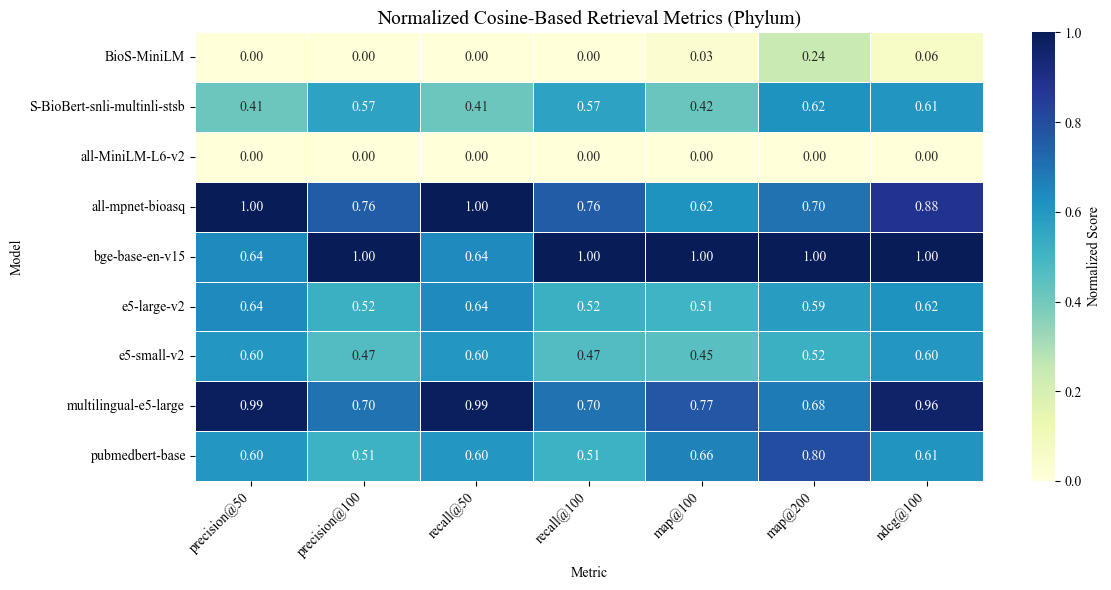

In [ ]:


# Assume sample_table is already defined as your DataFrame
# Set the index to Model_ID if it's not already
if sample_table_clean.index.name != "Model_ID":
    sample_table_clean.index.name = "Model_ID"

# Step 1: Normalize the metrics to [0, 1] for visual fairness
normalized_sample = (sample_table_clean - sample_table_clean.min()) / (sample_table_clean.max() - sample_table_clean.min())

# Step 2: Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized_sample,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Normalized Score"}
)
plt.title("Normalized Cosine-Based Retrieval Metrics (Phylum)", fontsize=14)
plt.xlabel("Metric")
plt.ylabel("Model")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

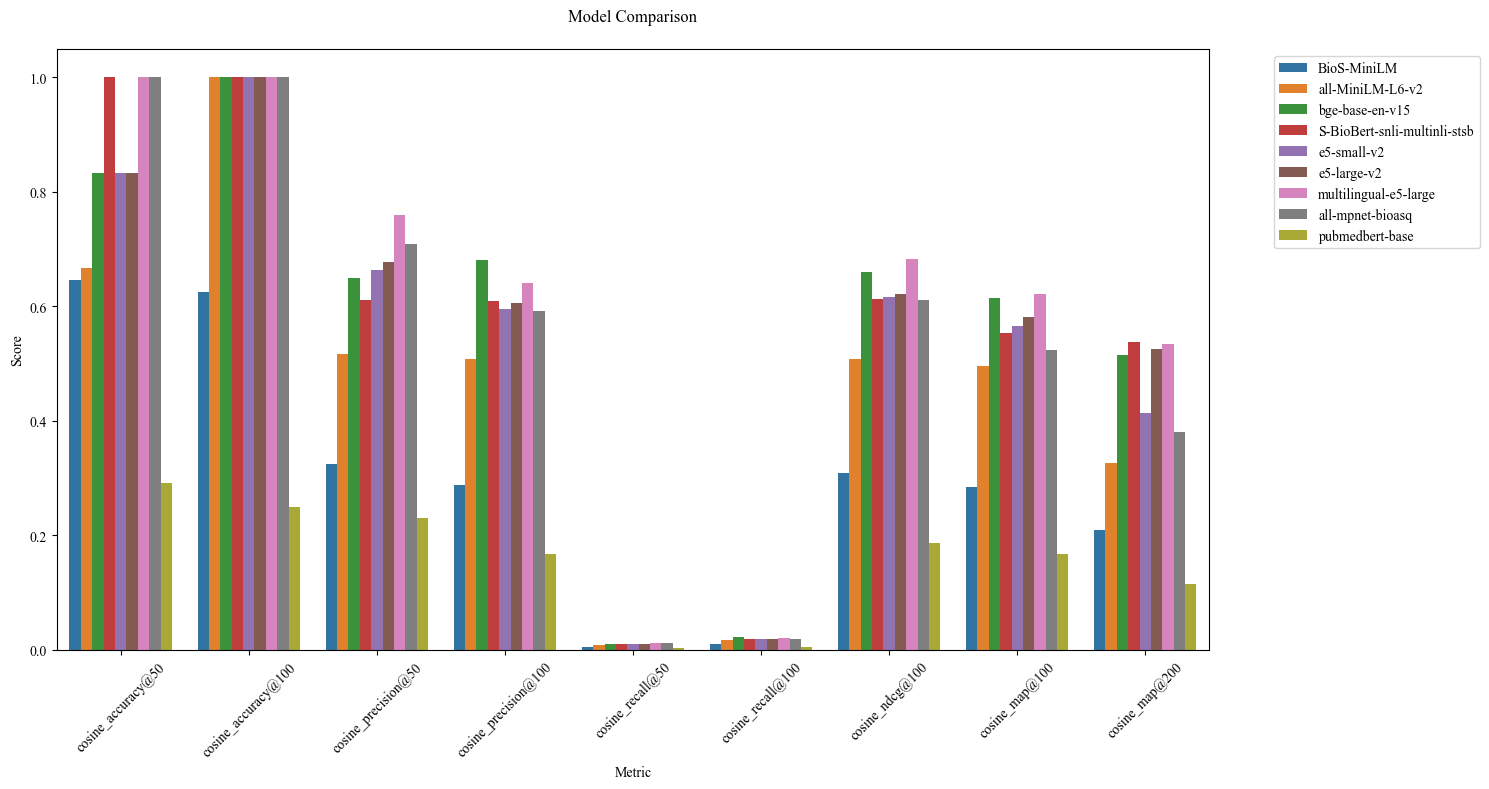

In [192]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(15, 8))
sns.barplot(
    data=combined_filtered,
    x='Metric',
    y='Score',
    hue='Model_ID',
    palette='tab10',
    ci=None 
)
plt.title('Model Comparison', pad=20)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

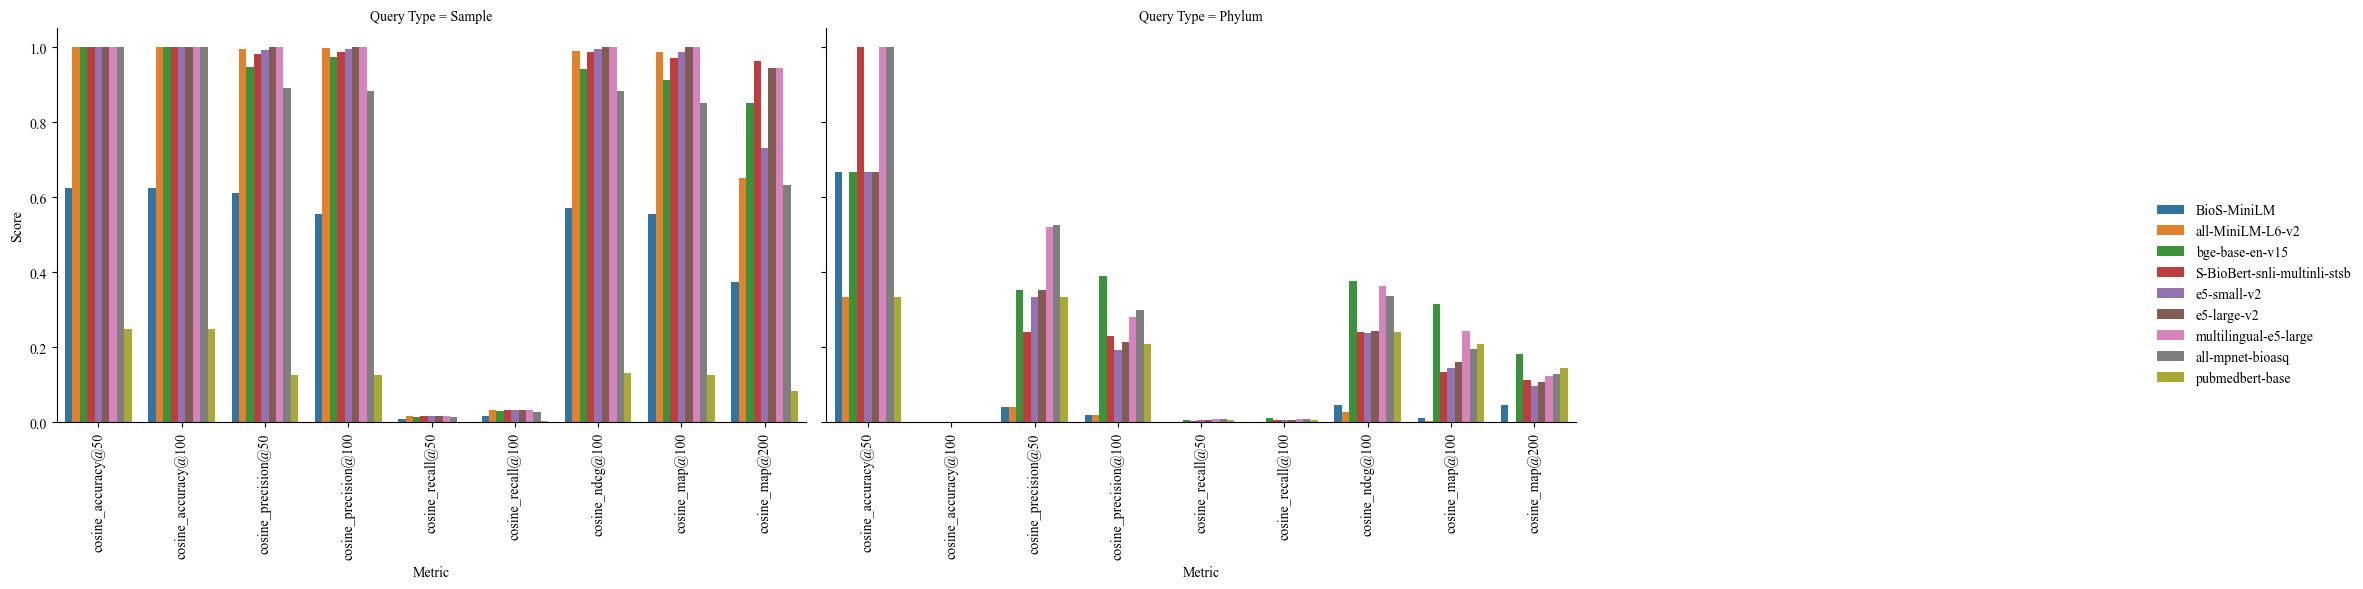

In [133]:


# Create a grid of plots for each Query Type
g = sns.FacetGrid(combined_filtered, col='Query Type', col_wrap=3, height=6, aspect=1.2)
g.map_dataframe(
    sns.barplot, 
    x='Metric', 
    y='Score', 
    hue='Model_ID',
    palette='tab10',
    dodge=True
)
g.set_xticklabels(rotation=90)
g.add_legend()
plt.tight_layout()
plt.show()

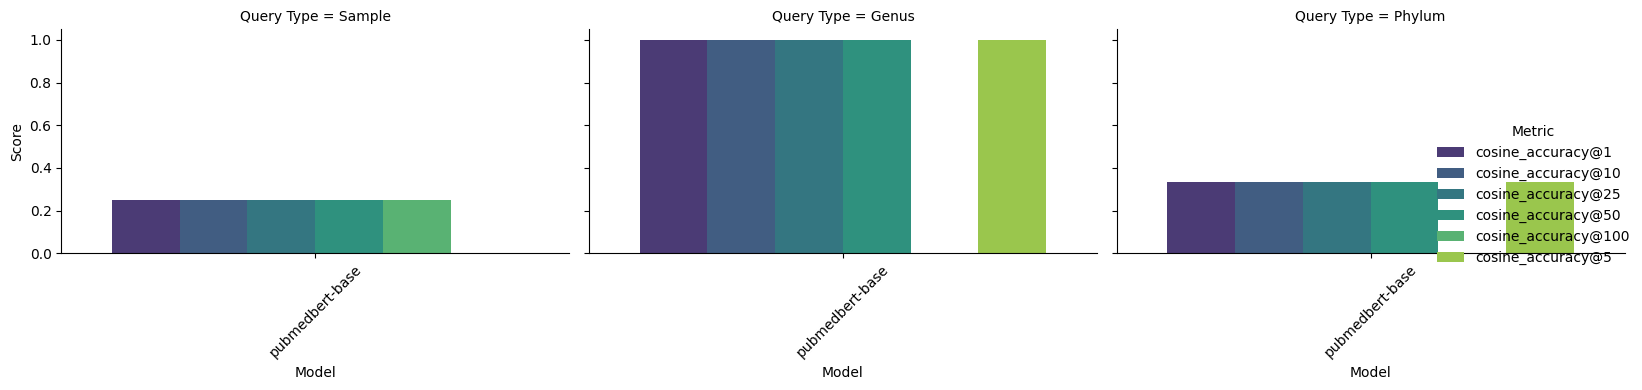

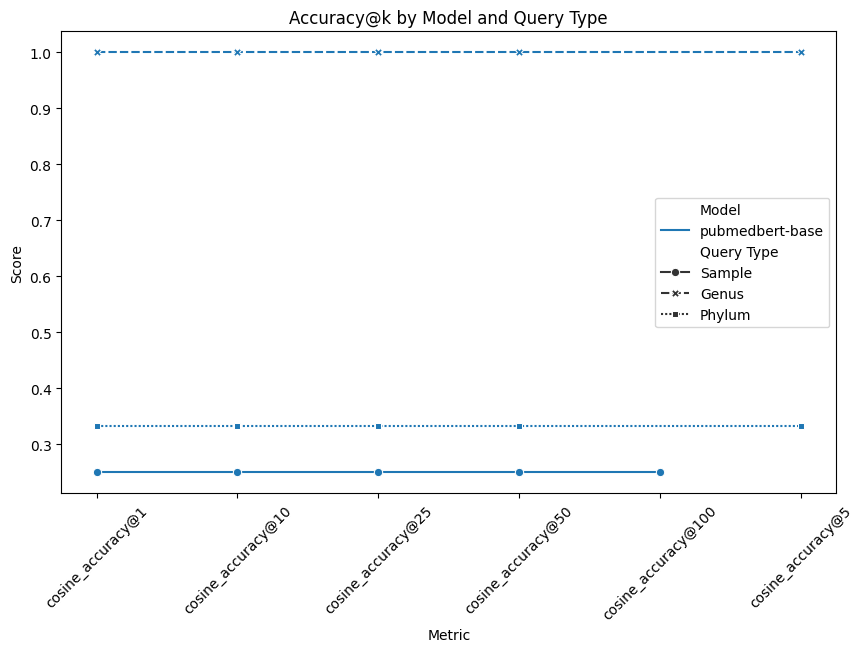

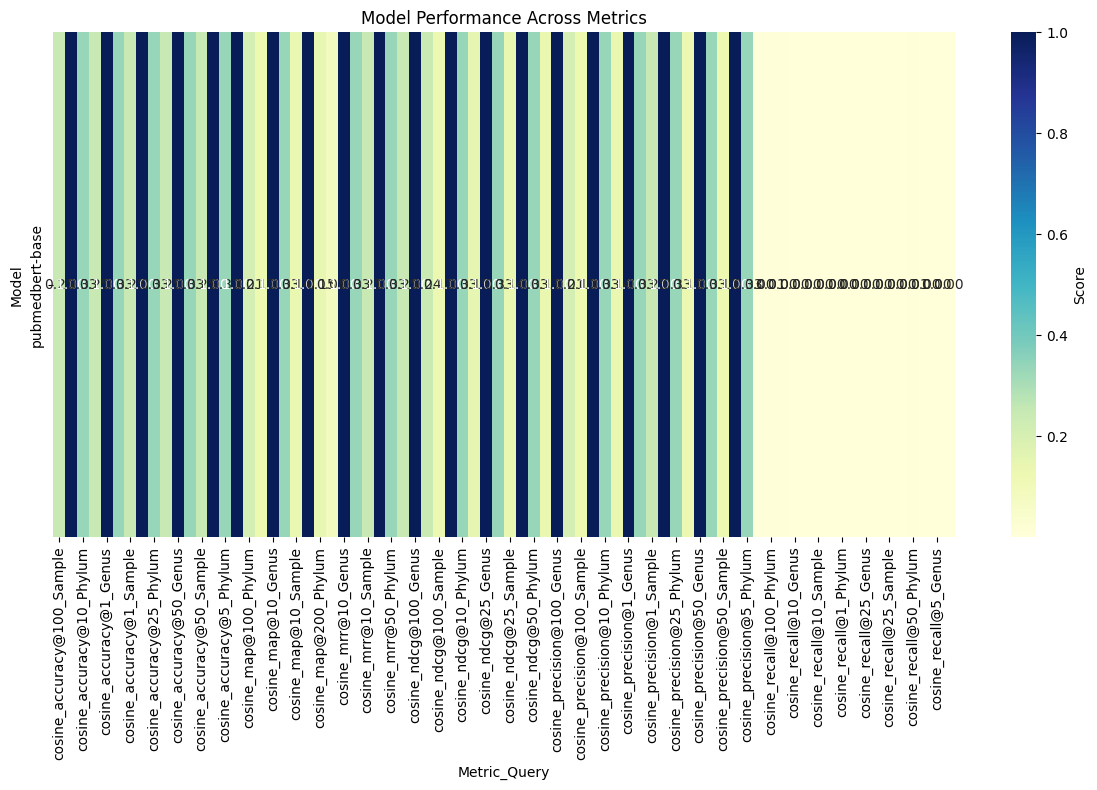

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is named 'df'

# 1. Faceted Bar Chart Example
g = sns.catplot(
    data=df[df['Metric'].str.contains('accuracy')],  # Filter for one metric type
    x='Model',
    y='Score',
    hue='Metric',  # Shows different k values
    col='Query Type',
    kind='bar',
    height=4,
    aspect=1.2,
    palette='viridis'
)
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

# 2. Line Plot Example for @k metrics
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df[df['Metric'].str.startswith('cosine_accuracy')],
    x='Metric',  # Or extract k value to a separate column
    y='Score',
    hue='Model',
    style='Query Type',
    markers=True
)
plt.xticks(rotation=45)
plt.title('Accuracy@k by Model and Query Type')
plt.show()

# 3. Heatmap Example
# First create a combined metric+query column
df['Metric_Query'] = df['Metric'] + "_" + df['Query Type']
heatmap_data = df.pivot(index='Model', columns='Metric_Query', values='Score')

plt.figure(figsize=(12,8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    cbar_kws={'label': 'Score'}
)
plt.title('Model Performance Across Metrics')
plt.tight_layout()
plt.show()

In [20]:
# First identify some taxa to hold out
all_genera = list(genus_to_samples.keys())
holdout_genera = random.sample(all_genera, min(3, len(all_genera)))  # Hold out 3 genera

# Create queries specifically about the held-out genera
holdout_queries = {}
holdout_relevant = {}

for i, genus in enumerate(holdout_genera):
    query_id = f"q_holdout_{i+1}"
    holdout_queries[query_id] = f"Which samples contain {genus} genus?"
    # We know the right answer but won't use these for training
    holdout_relevant[query_id] = set()
    for sample in genus_to_samples[genus]:
        holdout_relevant[query_id].update(sample_to_docs[sample])

# Add to main queries
queries.update(holdout_queries)
relevant_docs.update(holdout_relevant)

# Note: When training your system, you should exclude documents containing these genera
# from your training corpus to properly test generalization

INGESTION PROCESS



In [ ]:
import json
import os
from typing import Union, List, Dict
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import duckdb
import numpy as np
import faiss

def ingest(
    pdf_folder: str = None,
    table_rows: List[Dict[str, str]] = None,
    description: str = None,
    text_column: str = "text",
    metadata_columns: List[str] = None
):
    """
    Process either:
    - All PDFs in a folder, OR
    - Stringified table rows with metadata
    
    Args:
        pdf_folder: Path to folder containing PDFs
        table_rows: List of dictionaries (each representing a row)
        text_column: Column name containing text to embed
        metadata_columns: Columns to preserve as metadata
    """
    model = SentenceTransformer("intfloat/multilingual-e5-large")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1024,
        chunk_overlap=100,
    )

    # Initialize databases
    conn = duckdb.connect("document_vectors.db")
    conn.execute("""
    CREATE TABLE IF NOT EXISTS documents (
        id INTEGER PRIMARY KEY,
        text TEXT,
        source_type TEXT,
        source_id TEXT,
        metadata TEXT,
        embedding BLOB
    )
    """)
    
    embedding_dim = model.get_sentence_embedding_dimension()
    index = faiss.IndexFlatIP(embedding_dim)
    doc_id = 1

    # Process PDFs if folder provided
    if pdf_folder and os.path.exists(pdf_folder):
        for filename in os.listdir(pdf_folder):
            if not filename.lower().endswith('.pdf'):
                continue
                
            filepath = os.path.join(pdf_folder, filename)
            loader = PyPDFLoader(filepath)
            pages = loader.load_and_split()
            chunks = text_splitter.split_documents(pages)
            
            texts = [doc.page_content for doc in chunks]
            embeddings = model.encode(texts, normalize_embeddings=True).astype('float32')
            index.add(embeddings)
            
            for chunk_idx, (doc, emb) in enumerate(zip(chunks, embeddings)):
                conn.execute("""
                INSERT INTO documents VALUES (?, ?, ?, ?, ?, ?)
                """, [
                    doc_id,
                    doc.page_content,
                    "pdf",
                    f"{filename}_p{doc.metadata.get('page', 0)}",
                    json.dumps({
                        **{"chunk_idx": chunk_idx},
                        **{k: str(v) for k, v in doc.metadata.items()}
                    }),
                    emb.tobytes()   

                ])
                doc_id += 1

    # Process table rows if provided
    if table_rows:
        texts = [row[text_column] for row in table_rows]
        embeddings = model.encode(texts, normalize_embeddings=True).astype('float32')
        index.add(embeddings)
        
        # Prepare batch insert
        batch_data = []
        for row_idx, (row, emb) in enumerate(zip(table_rows, embeddings)):
            metadata = {
                k: str(v) 
                for k, v in row.items() 
                if metadata_columns is None or k in metadata_columns
            }
            if description:
                metadata['table_description'] = str(description)

            batch_data.append([
                doc_id + row_idx,
                row[text_column],
                "table",
                f"row_{row_idx}",
                json.dumps(metadata),
                emb.tobytes()
            ])
    
    # Execute batch insert
    conn.executemany("""
    INSERT INTO documents VALUES (?, ?, ?, ?, ?, ?)
    """, batch_data)
    doc_id += len(table_rows)

    # Save resources
    faiss.write_index(index, "docs.faiss")
    conn.close()
    return "document_vectors.db", "docs.faiss"


In [ ]:
# conn = duckdb.connect("document_vectors.db")

# # Count rows
# print("Row count:", conn.execute("SELECT COUNT(*) FROM documents").fetchone()[0])

# # See a few existing IDs and sources
# print(conn.execute("SELECT id, source_type, source_id FROM documents LIMIT 5").fetchall())
# # conn.execute("DELETE FROM documents")
# conn.close()
# con.close()

CatalogException: Catalog Error: Table with name documents does not exist!
Did you mean "document_vectors.documents"?

LINE 1: SELECT COUNT(*) FROM documents
                             ^

In [39]:
con = duckdb.connect("document_vectors.db")
con.execute("DROP TABLE IF EXISTS features")
con.close()

In [70]:
gpt = pd.read_csv("evaluation_results_gpt.csv")
olmo = pd.read_csv("evaluation_results_olmo.csv")
llama = pd.read_csv("evaluation_results_llama.csv")
pythia = pd.read_csv("evaluation_results_pythia.csv")

In [71]:
for i in range(20):
    print(gpt['question'][i])

What is the total number of features detected in sample 1?
Which genus had the highest abundance in sample 2?
What phylum is dominant in sample 3
Is feature 27 present in sample 4?
What is the NCBI taxonomy of feature 2?
Which feature contributes the most to the total reads in sample 5?
Is the genus with the highest abundance also the dominant phylum?
Which feature among the top 5 in sample 6 has the lowest abundance?
What is the percentage contribution of Feature1 to the total reads in sample 7?
Does sample 8 not have any abundant features with genus 'microbacter'?
If the experiment focuses on rare genera, which top feature from Sample 3 qualifies as rare?
If we only consider genera with known genus names, how many top features remain in sample 3?
If proteobacteria is excluded, which phylum has the highest abundance?
If feature 27s abundance is 0 in one row and 23 in another, should it be considered active?
If Feature1 were removed, which genus would become most abundant in sample 6?


In [72]:
gpt["Model"] = "GPT-4o-mini"
olmo["Model"] = "OLMo 1B"
llama["Model"] = "Llama-3.2 1B"
pythia["Model"] = "Pythia 1.4B"

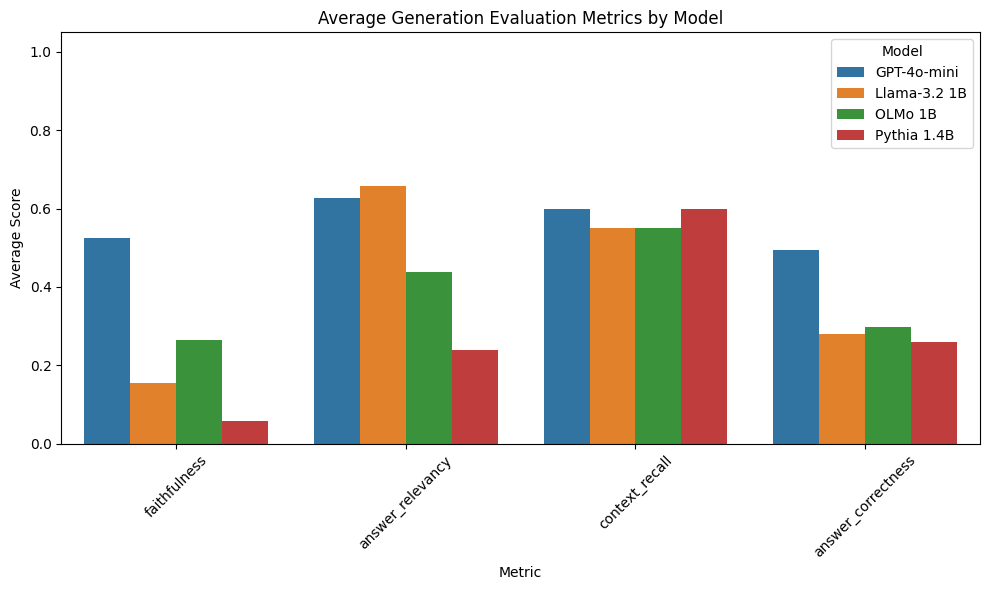

In [77]:
combined_df = pd.concat([gpt, llama, olmo, pythia], ignore_index=True)


# Define the metric columns to average
metrics = ["faithfulness", "answer_relevancy", "context_recall", "answer_correctness"]

# Compute averages
avg_scores = combined_df.groupby("Model")[metrics].mean().reset_index()

# Reshape for plotting
melted = avg_scores.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("Average Generation Evaluation Metrics by Model")
plt.ylabel("Average Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

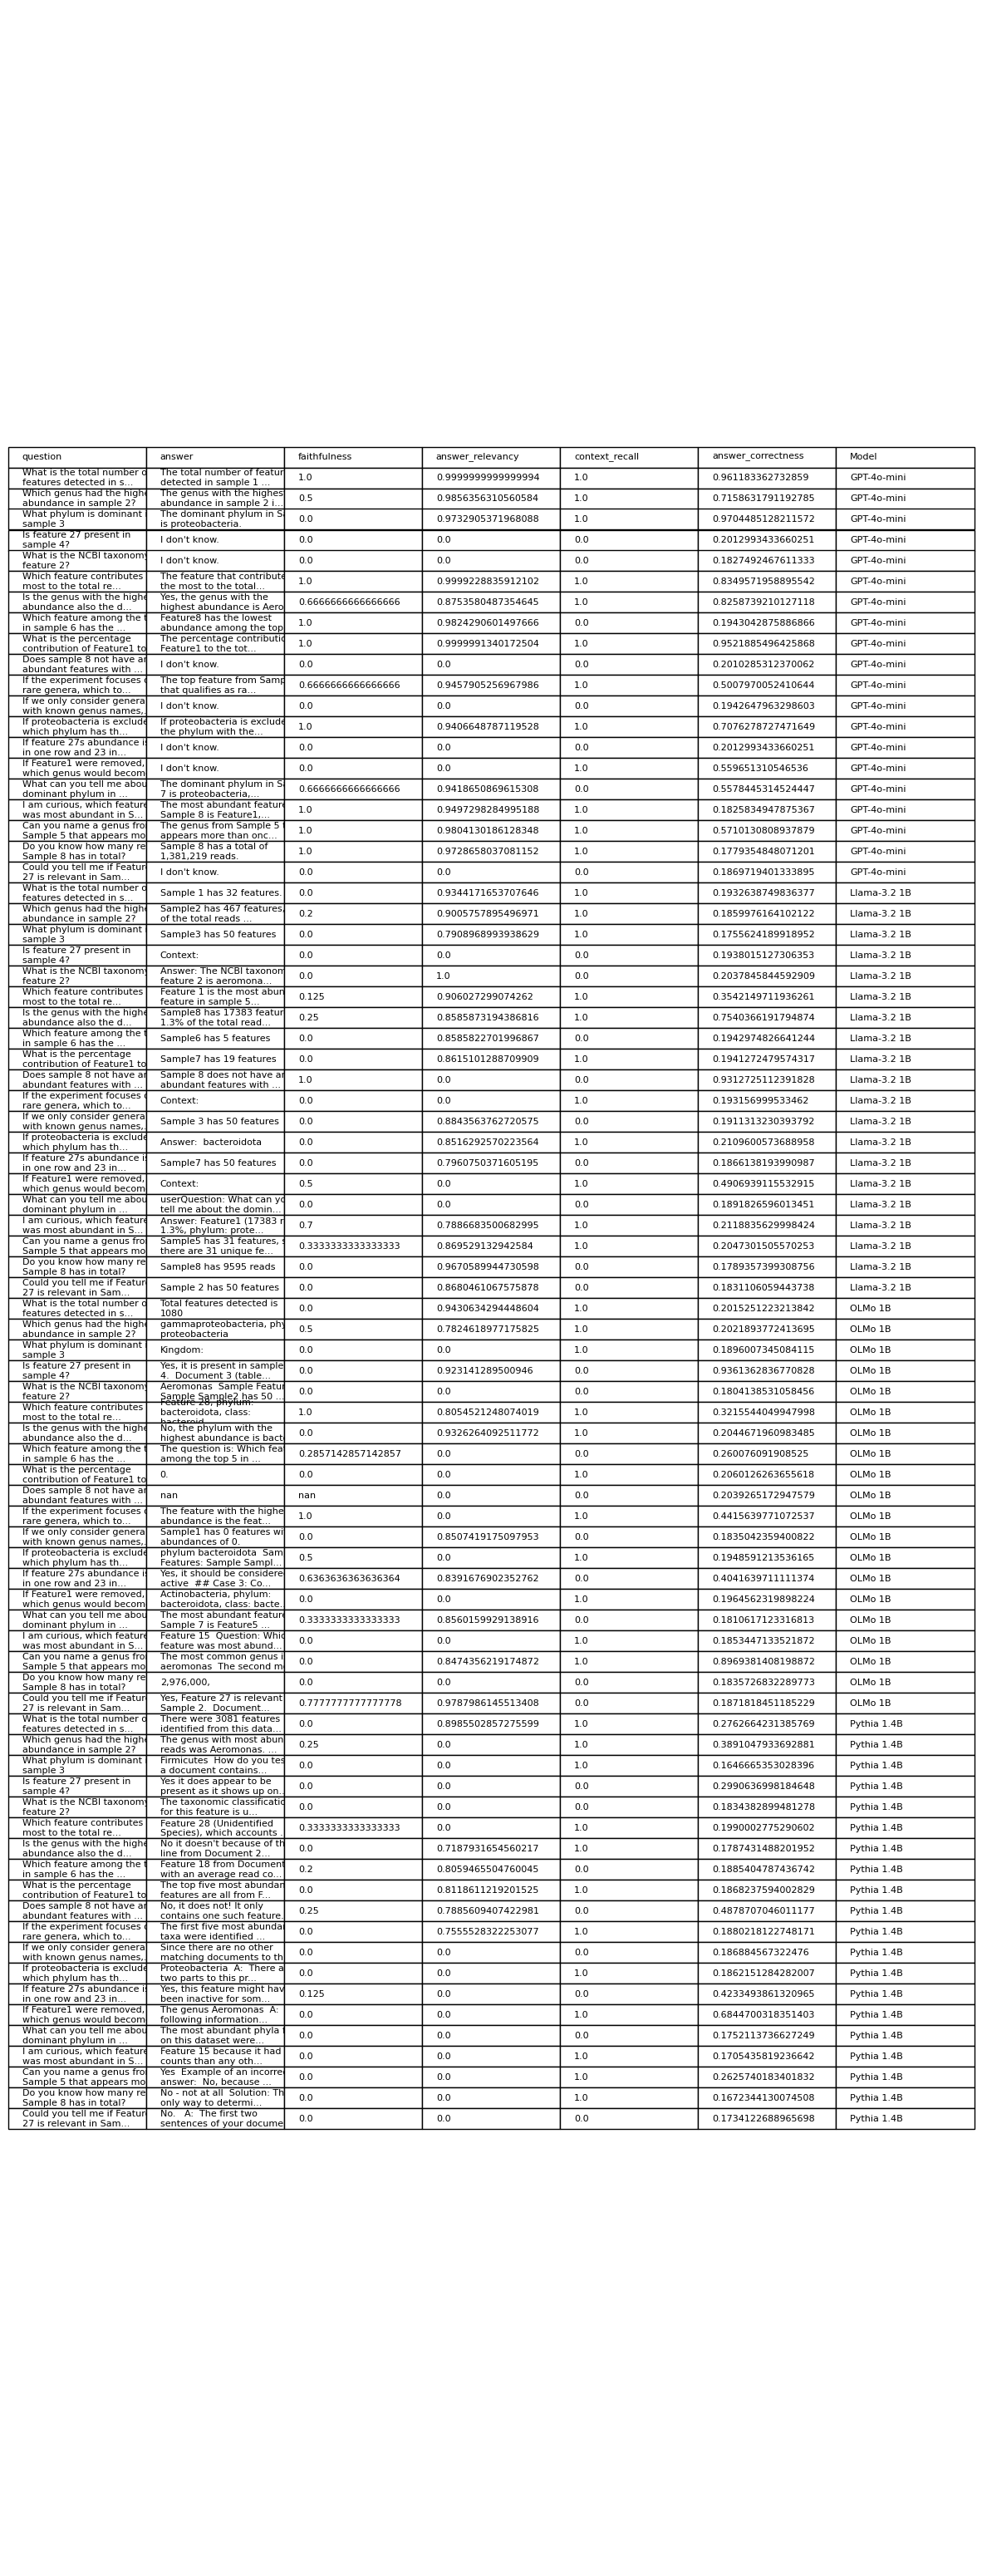

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Assuming combined_df is already defined with your columns
# Truncate long text for better table display if needed
max_col_width = 50
df_display = combined_df.copy()

df_display = df_display.astype(str)

max_col_width = 50
df_display['question'] = df_display['question'].apply(
    lambda x: x[:max_col_width] + '...' if len(x) > max_col_width else x
)
df_display['answer'] = df_display['answer'].apply(
    lambda x: x[:max_col_width] + '...' if len(x) > max_col_width else x
)




df_display['question'] = df_display['question'].apply(lambda x: x[:max_col_width] + '...' if len(x) > max_col_width else x)
df_display['answer'] = df_display['answer'].apply(lambda x: x[:max_col_width] + '...' if len(x) > max_col_width else x)

import textwrap

def wrap_text(text, width):
    return '\n'.join(textwrap.wrap(text, width=width))

wrap_width = 30  # characters before wrapping

df_display['question'] = df_display['question'].apply(lambda x: wrap_text(x, wrap_width))
df_display['answer'] = df_display['answer'].apply(lambda x: wrap_text(x, wrap_width))

# Create a figure for the table
fig, ax = plt.subplots(figsize=(15, len(df_display) * 0.5))  # Adjust height based on number of rows
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df_display.values,
                 colLabels=df_display.columns,
                 loc='center',
                 cellLoc='left',
                 colLoc='left')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)  # Adjust as needed for better spacing

# Save to PDF
with PdfPages("combined_df_table.pdf") as pdf:
    pdf.savefig(fig, bbox_inches='tight')



In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import textwrap

def wrap_text(text, width):
    return '\n'.join(textwrap.wrap(text, width=width))

def plot_table(df, filename, pdf=None):
    fig, ax = plt.subplots(figsize=(15, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='left',
                     colLoc='left')

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)

    if pdf:
        pdf.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig(filename, bbox_inches='tight')

    plt.close(fig)

# --- Preprocessing ---
df_display = combined_df.copy().astype(str)

wrap_width = 30
for col in ['question', 'answer']:
    df_display[col] = df_display[col].apply(lambda x: wrap_text(x, wrap_width))

# --- Split the dataframe in half ---
midpoint = len(df_display) // 2
df_part1 = df_display.iloc[:midpoint]
df_part2 = df_display.iloc[midpoint:]

# --- Save both parts into a single PDF ---
with PdfPages("combined_df_split.pdf") as pdf:
    plot_table(df_part1, None, pdf)
    plot_table(df_part2, None, pdf)


In [75]:
pd.set_option('display.max_rows', 500)

combined_df["question"] = [i%20+1 for i in range(0,80)]

combined_df[["Model", "question", "faithfulness", "answer_relevancy", "context_recall", "answer_correctness"]]


# Select relevant numeric columns and group by 'Model'
metrics = ["faithfulness", "answer_relevancy", "context_recall", "answer_correctness"]
grouped_df = combined_df.groupby("Model")[metrics].mean().reset_index()

grouped_df


,Model,faithfulness,answer_relevancy,context_recall,answer_correctness
0,GPT-4o-mini,0.525000,0.627398,0.60,0.493994
1,Llama-3.2 1B,0.155417,0.656798,0.55,0.281038
2,OLMo 1B,0.264905,0.437945,0.55,0.298027
3,Pythia 1.4B,0.057917,0.238963,0.60,0.258572


In [76]:


# Convert to LaTeX
latex_table = grouped_df.to_latex(index=False, float_format="%.3f", caption="Evaluation metrics per question and model.", label="tab:qa-evaluation")

latex_table

'\\begin{table}\n\\caption{Evaluation metrics per question and model.}\n\\label{tab:qa-evaluation}\n\\begin{tabular}{lrrrr}\n\\toprule\nModel & faithfulness & answer_relevancy & context_recall & answer_correctness \\\\\n\\midrule\nGPT-4o-mini & 0.525 & 0.627 & 0.600 & 0.494 \\\\\nLlama-3.2 1B & 0.155 & 0.657 & 0.550 & 0.281 \\\\\nOLMo 1B & 0.265 & 0.438 & 0.550 & 0.298 \\\\\nPythia 1.4B & 0.058 & 0.239 & 0.600 & 0.259 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'